<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Chapter-Goals" data-toc-modified-id="Chapter-Goals-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Chapter Goals</a></span></li><li><span><a href="#Chapter-Outline" data-toc-modified-id="Chapter-Outline-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Chapter Outline</a></span></li><li><span><a href="#Applications-of-Gaussian-Mixture-Models" data-toc-modified-id="Applications-of-Gaussian-Mixture-Models-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Applications of Gaussian Mixture Models</a></span></li><li><span><a href="#Using-GMMs-to-Predict-Return-Distributions" data-toc-modified-id="Using-GMMs-to-Predict-Return-Distributions-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Using GMMs to Predict Return Distributions</a></span><ul class="toc-item"><li><span><a href="#Benchmark-model-with-N-components-=-1" data-toc-modified-id="Benchmark-model-with-N-components-=-1-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Benchmark model with N components = 1</a></span></li><li><span><a href="#Evaluate-GMM-accuracy-in-predicting-confidence-intervals" data-toc-modified-id="Evaluate-GMM-accuracy-in-predicting-confidence-intervals-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Evaluate GMM accuracy in predicting confidence intervals</a></span></li><li><span><a href="#Wrap-Walkforward-Functions-into-Larger-Functions" data-toc-modified-id="Wrap-Walkforward-Functions-into-Larger-Functions-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Wrap Walkforward Functions into Larger Functions</a></span></li><li><span><a href="#Model-with-N-components-=-2" data-toc-modified-id="Model-with-N-components-=-2-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Model with N components = 2</a></span><ul class="toc-item"><li><span><a href="#Save-the-prediction-dataframe-and-output-accuracy-of-the-two-component-model." data-toc-modified-id="Save-the-prediction-dataframe-and-output-accuracy-of-the-two-component-model.-4.4.1"><span class="toc-item-num">4.4.1&nbsp;&nbsp;</span>Save the prediction dataframe and output accuracy of the two-component model.</a></span></li><li><span><a href="#Evaluate-2-component-model-prediction-accuracy" data-toc-modified-id="Evaluate-2-component-model-prediction-accuracy-4.4.2"><span class="toc-item-num">4.4.2&nbsp;&nbsp;</span>Evaluate 2 component model prediction accuracy</a></span></li></ul></li></ul></li><li><span><a href="#Design-and-implement-an-event-study-based-on-post-outlier-returns" data-toc-modified-id="Design-and-implement-an-event-study-based-on-post-outlier-returns-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Design and implement an event study based on post outlier returns</a></span></li><li><span><a href="#Evaluate-Event-Study" data-toc-modified-id="Evaluate-Event-Study-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Evaluate Event Study</a></span></li><li><span><a href="#Run/Eval-Event-Study-with-Different-Buy-Thresholds" data-toc-modified-id="Run/Eval-Event-Study-with-Different-Buy-Thresholds-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Run/Eval Event Study with Different Buy Thresholds</a></span></li><li><span><a href="#Conclusions-(Updated-2018-06-01)" data-toc-modified-id="Conclusions-(Updated-2018-06-01)-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Conclusions (Updated 2018-06-01)</a></span></li></ul></div>

## Chapter Goals

1. Use walkforward analysis to evaluate GMM prediction accuracy
2. Design an event study
* Use results to determine if any tradeable patterns exist

## Chapter Outline

In this notebook we will:
1. Discuss some applications of GMM in finance
2. Use GMM to predict return distribution
2. Evaluate GMM accuracy in predicting confidence intervals
3. Design and implement an event study based on "outlier" returns
4. Evaluate Event Study
5. Conclusions

In [1]:
%load_ext watermark
%watermark

%load_ext autoreload
%autoreload 2

from IPython.display import display
from IPython.core.debugger import set_trace as bp
# import standard libs
from pathlib import PurePath, Path
import sys
import time
import os
import pickle
os.environ['THEANO_FLAGS'] = 'device=cpu,floatX=float32'
from itertools import count

# get project dir
pp = PurePath(Path.cwd()).parts[:-1]
pdir = PurePath(*pp)
data_dir = pdir/'data'
script_dir = pdir / 'scripts' 
viz_dir = pdir / 'visuals' / '03_Strategy_Research'
sys.path.append(script_dir.as_posix())

# import python scientific stack
import pandas as pd
from pandas.tseries import converter
converter.register()
import pandas_datareader.data as web
import numpy as np
import sklearn.mixture as mix
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
from sklearn.model_selection import TimeSeriesSplit
import math

# import visual tools
from mpl_toolkits import mplot3d
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
savefig_kwds = dict(dpi=300, bbox_inches='tight')
%matplotlib inline
import plotnine as pn
import mizani.breaks as mzb
import mizani.formatters as mzf
import seaborn as sns
savefig_kwds=dict(dpi=300, bbox_inches='tight')

# import util libs
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from utils import cprint, make_gmm, make_ic_series

# set globals
plt.style.use('seaborn-talk')
plt.style.use('bmh')
plt.rcParams['font.family'] = 'Bitstream Vera Sans'#'DejaVu Sans Mono'
#plt.rcParams['font.size'] = 9.5
plt.rcParams['font.weight'] = 'medium'
plt.rcParams['figure.figsize'] = 10,7

blue, green, red, purple, gold, teal = sns.color_palette('colorblind', 6)
RANDOM_STATE = 777

print()
%watermark -p pandas,pandas_datareader,numpy,sklearn,statsmodels,scipy,pymc3,matplotlib,seaborn,plotnine

2018-06-02T21:30:14-06:00

CPython 3.6.4
IPython 6.2.1

compiler   : GCC 4.8.2 20140120 (Red Hat 4.8.2-15)
system     : Linux
release    : 4.13.0-43-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 12
interpreter: 64bit


/media/bcr/HDD/anaconda3/envs/bayes_dash/lib/python3.6/site-packages/ipykernel/__main__.py:29: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 



pandas 0.23.0
pandas_datareader 0.6.0+21.gda18fbd
numpy 1.14.3
sklearn 0.19.1
statsmodels 0.9.0
scipy 1.1.0
pymc3 3.4.1
matplotlib 2.1.2
seaborn 0.8.1
plotnine 0.3.0


## Applications of Gaussian Mixture Models

1. Predicting Return Distributions
    * for example classifying returns as outliers for filtering/cleaning data.
2. Risk Management 
    - Trade Filters
    - Position Sizing Filters
    - Veto Trades
    - As an example if we predict a volatile regime moving forward we want to reduce position sizing or maybe not trade at all.
3. Signals/Indicator
    - For example initiating positions when predicting certain regimes.

In this notebook we will research some of the ways we can use `GMMs` in trading applications.

## Using GMMs to Predict Return Distributions

In this section we will implement a GMM to iteratively predict the distribution for our lookahead period. To do this we will make sure of `sklearn's` `TimeSeriesSplit()` function, which increments train/test data sets sequentially. This is to avoid the loss of autocorrelation information caused by using traditional cross validation techniques, which assume that the data is [IID](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables). 

First we load the dataset.

In [2]:
infp = PurePath(data_dir/'etf_prices_2004-11-19-2017-12-31.parq')
prices = (pd.read_parquet(infp)) # add year column for later conv.
cprint(prices)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
               SPY     QQQ     TLT     GLD    EFA    EEM
Date                                                    
2017-12-25  267.51  157.37  124.77  120.94  70.11  46.50
2017-12-26  267.19  156.52  125.14  121.77  70.09  46.46
2017-12-27  267.32  156.54  126.77  122.23  70.22  46.58
2017-12-28  267.87  156.73  126.66  122.85  70.26  46.90
2017-12-29  266.86  155.76  126.86  123.65  70.31  47.12
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6300 entries, 1993-11-08 to 2017-12-29
Data columns (total 6 columns):
SPY    6300 non-null float64
QQQ    4908 non-null float64
TLT    4030 non-null float64
GLD    3422 non-null float64
EFA    4274 non-null float64
EEM    3845 non-null float64
dtypes: float64(6)
memory usage: 344.5 KB
None
-----------------------

In [3]:
infp = PurePath(data_dir/'etf_returns_2004-11-19-2017-12-31.parq')
R = (pd.read_parquet(infp)
     .assign(year=lambda df: df.index.year)) # add year column for later conv.
cprint(R)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                 SPY       QQQ       TLT       GLD       EFA       EEM  year
Date                                                                        
2017-12-25  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  2017
2017-12-26 -0.001197 -0.005416  0.002961  0.006839 -0.000285 -0.000861  2017
2017-12-27  0.000486  0.000128  0.012941  0.003770  0.001853  0.002580  2017
2017-12-28  0.002055  0.001213 -0.000868  0.005060  0.000569  0.006846  2017
2017-12-29 -0.003778 -0.006208  0.001578  0.006491  0.000711  0.004680  2017
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3421 entries, 2004-11-19 to 2017-12-29
Data columns (total 7 columns):
SPY     3421 non-null float64
QQQ     3421 non-null float64
TLT     3421 non-null float64
GLD     3421 n

### Benchmark model with N components = 1

Next we choose the example symbol's returns.

In [4]:
sym = 'SPY' # example symbol
s = R[sym].copy() 
cprint(s)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                 SPY
Date                
2017-12-25  0.000000
2017-12-26 -0.001197
2017-12-27  0.000486
2017-12-28  0.002055
2017-12-29 -0.003778
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3421 entries, 2004-11-19 to 2017-12-29
Data columns (total 1 columns):
SPY    3421 non-null float64
dtypes: float64(1)
memory usage: 53.5 KB
None
-------------------------------------------------------------------------------



Now we can run the walkforward analysis. The next cell implements the `TimeSeriesSplit` method from `sklearn`. Essentially we iterate over each day using the previous data to estimate the model parameters and make a prediction about the next day's return distribution. We save the key prediction information and results each day and then combine that into a `df` for easy analysis. In this example we will baseline our study by using a single mixture component.

*I have heavily commented the code below if you are interested in more details.*

In [5]:
%%time

np.random.seed(0)

lookback = 252 * 1
n_components = 1 # baseline
n_split = len(s) - 1 # since we are iterating daily we need 1 less than total series for splits

tscv = TimeSeriesSplit(n_splits=n_split, max_train_size=lookback)

alpha = 0.95 # for sampling confidence intervals
pred_rows = [] # init list to hold df rows
c = count(1) # init counter

for i, (train, test) in enumerate(tscv.split(s)):
    if next(c) < lookback: # add training data until min lookback
        continue

    ### set up train/test data ###
    # temp train data as pd.Series
    tmp_train = s.iloc[train]
    X_train = tmp_train.values.reshape(-1, 1) # must reshape for sklearn
    # temp test data as pd.Series
    #  returns pd.Series with shape (1,)
    tmp_test = s.iloc[test]
    X_test = tmp_test.values.reshape(1, -1) # must reshape
    
    ### fit GMM ###
    gmm = make_gmm(n_components).fit(X_train)
    hidden_states = gmm.predict(X_train) # extract hidden states 
    
    ### get last state estimate ###
    last_state = hidden_states[-1]
    last_mean = gmm.means_[last_state]
    last_var = np.diag(gmm.covariances_[last_state])

    ### sample from distribution using last state parameters ###
    # must choose number of samples
    n_samples = 1000
    rvs = stats.norm.rvs(loc=last_mean, scale=np.sqrt(last_var), size=n_samples)
    low_ci, high_ci = stats.norm.interval(alpha=alpha, loc=np.mean(rvs), scale=np.std(rvs))

    ### store data into rows ###
    # columns: cols = ['Dates', 'ith_state', 'ith_ret','ith_std',
    # 'low_ci', 'high_ci', 'actual_return']
    pred_rows.append((tmp_test.index[0], last_state, last_mean[0], np.sqrt(last_var[0]), 
                      low_ci, high_ci, X_test.ravel()[0]))    

CPU times: user 3min 35s, sys: 0 ns, total: 3min 35s
Wall time: 3min 35s


Next we create the dataframe to hold the prediction information. In this step we also add the accuracy information about whether the actual return fell within our predicted interval.

In [6]:
def in_range(df):
    """fn: add binary column for predictions within CI"""
    wins = df.query("low_ci < actual_return < high_ci").index
    in_list = [1 if i in wins else 0 for i in df.index]
    df = df.assign(in_range=in_list)
    return df

### make prediction df ###
cols = ['Dates', 'ith_state', 'ith_ret','ith_std',
        'low_ci', 'high_ci', 'actual_return']
pred_df = (pd.DataFrame(pred_rows, columns=cols)
           .pipe(in_range))

cprint(pred_df)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
          Dates  ith_state   ith_ret   ith_std    low_ci   high_ci  \
3164 2017-12-25          0  0.000659  0.004321 -0.007982  0.009253   
3165 2017-12-26          0  0.000662  0.004320 -0.008117  0.009064   
3166 2017-12-27          0  0.000643  0.004317 -0.007738  0.008893   
3167 2017-12-28          0  0.000658  0.004310 -0.007949  0.009408   
3168 2017-12-29          0  0.000666  0.004311 -0.007959  0.009078   

      actual_return  in_range  
3164       0.000000         1  
3165      -0.001197         1  
3166       0.000486         1  
3167       0.002055         1  
3168      -0.003778         1  
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3169 entries, 0 to 3168
Data columns (total 8 columns):
Dates            3169 non-null datetime64[ns]
it

### Evaluate GMM accuracy in predicting confidence intervals

Now we can plot the output and assess the accuracy of the distribution predictions.

In [9]:
def plot_cuml_preds(pred_df):
    df = pred_df#.set_index('Dates')
    n = df.shape[0]
    nRight = df.query('in_range==1').shape[0]
    accuracy = nRight / n
    
    colors = sns.color_palette('RdYlBu', 4)
    fig, ax = plt.subplots(figsize=(10, 7))
    marker_size = [2 if x==1 else 20 for x in df['in_range']]
    alpha_list = [0.25 if x==1 else .9 for x in df['in_range']]
    ax.scatter(df.query('in_range==1').index, df.query('in_range==1')['actual_return'].cumsum(),
               alpha=.9, s=marker_size,
               c=[blue if x == 1 else red for x in df['in_range']])

    ax.set_xlim(df.index[0], df.index[-1])

    ax.set_title(f'accuracy: {accuracy:2.2%} | outliers: {n-nRight} | samples: {n}')

    win_kwds = dict(color="white", marker='o', markersize=10)
    in_ = mpl.lines.Line2D(range(1), range(1),
        markerfacecolor=colors[1], **win_kwds)
    out_ = mpl.lines.Line2D(range(1), range(1),
        markerfacecolor=colors[0], **win_kwds)
    ci_kwds = dict(color="white", marker='.', markersize=10)
    leg = ax.legend([in_, out_], ["in", "out"],
                    loc="center left", bbox_to_anchor=(1, 0.85), numpoints=1)
    leg.get_frame().set_edgecolor('blue')
    sns.despine(offset=2)
    return 
    

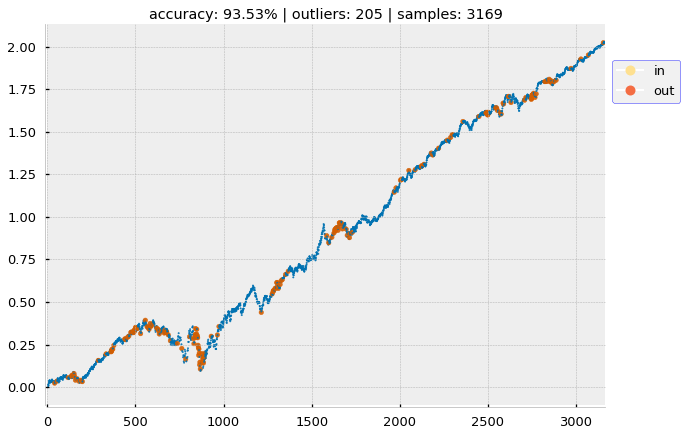

In [10]:
### plot ###
plot_cuml_preds(pred_df)
plt.savefig(PurePath(viz_dir / f'{sym}_cuml_returns_outliers_ex.png').as_posix(), **savefig_kwds)

In [11]:
def plot_distr_accuracy(df, state_col=None):
    n = df.shape[0]
    nRight = df.query('in_range==1').shape[0]
    accuracy = nRight / n
    
    g = (pn.ggplot(df.reset_index(), pn.aes(x='Dates',y='actual_return', color=f'factor({state_col})')) 
         + pn.geom_point(pn.aes(shape=f'factor({state_col})'), alpha=0.75)
         + pn.geom_hline(yintercept=0., size=1, linetype=':', color='red')
         + pn.scale_y_continuous(breaks=mzb.mpl_breaks(),
                                 labels=mzf.percent_format(),
                                 limits=(df['actual_return'].min(), df['actual_return'].max()))
         + pn.scale_x_datetime(breaks=mzb.date_breaks('1 years'),
                               labels=mzf.date_format('%Y'))         
         + pn.theme_linedraw()
         + pn.theme(panel_background=pn.element_rect(fill='black'), 
                    axis_text_x=pn.element_text(rotation=50),
                    text=pn.element_text(size=7)) 
         + pn.ylab('log returns')
         + pn.ggtitle(f'accuracy: {accuracy:2.2%} | outliers: {n-nRight} | samples: {n}'))
    return g

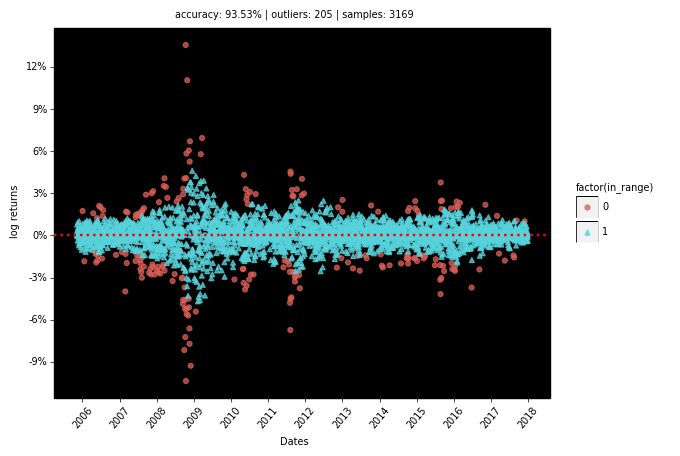

<ggplot: (-9223363275922550591)>


In [12]:
### plot ###
g = plot_distr_accuracy(pred_df, 'in_range')
print(g)
g.save(PurePath(viz_dir / f'{sym}_scatter_returns_outliers_ex.png').as_posix(), **savefig_kwds)

Naturally one may be curious how many outliers there were per period _(year, month)_ for the purposes of ascertaining how many potential trading opportunities there are assuming a trade can be entered at each outlier point.

In [13]:
def plot_outliers_bar(pred_df, period='A'):
    grp = pred_df.groupby([pd.TimeGrouper(period)])['in_range'] 
    df = ((grp.count() - grp.sum())
          .reset_index()
          .rename(columns={'index':'Dates','in_range':'outliers'})
          .assign(year=lambda df: df['Dates'].dt.year))

    period_map = dict(A='Annual', M='Monthly')
    dodge_text = pn.position_dodge(width=0.9)
    g = (pn.ggplot(df, pn.aes(x='Dates', y='outliers', color='factor(year)'))
         + pn.geom_bar(stat='identity', width=5.)#, position=pn.position_dodge(width=1))
         + pn.scale_y_continuous(breaks=mzb.mpl_breaks(),
                                 limits=(0, df['outliers'].max()))
         + pn.scale_x_datetime(breaks=mzb.date_breaks('1 year'),
                               labels=mzf.date_format('%Y'),)
         + pn.geom_text(pn.aes(label='outliers'),
                        position=dodge_text,
                        size=7, va='bottom')
         + pn.theme_linedraw()
         + pn.theme(panel_background=pn.element_rect(fill='black'), 
                    axis_text_x=pn.element_text(rotation=50),
                    text=pn.element_text(size=7)) 
         + pn.ylab('outlier count')
         + pn.ggtitle(f'{period_map[period]} Count of Outliers'))
    return g

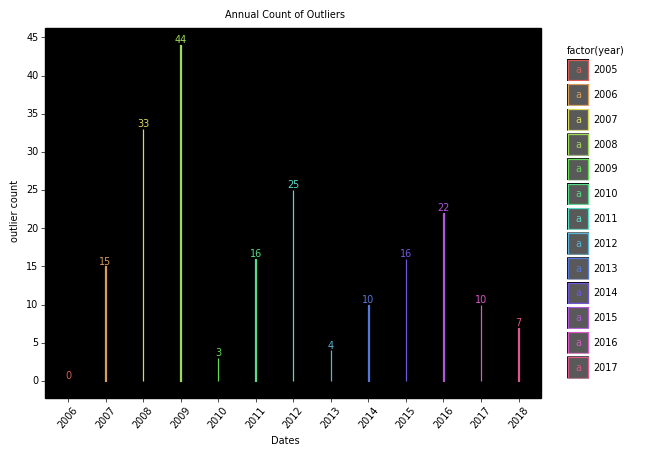

<ggplot: (-9223363275947460629)>


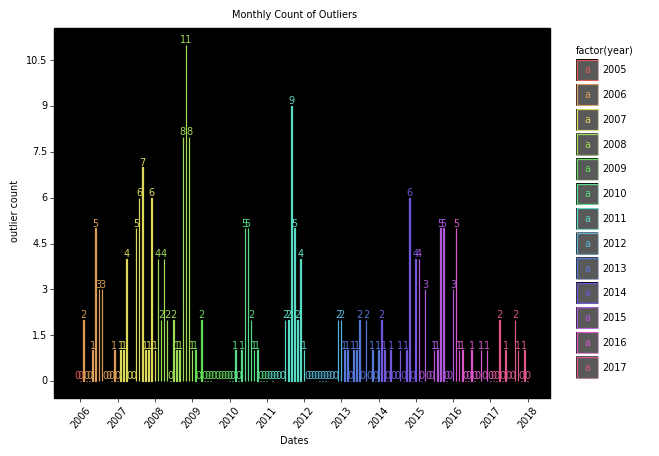

<ggplot: (-9223363275947489669)>


In [15]:
### plot ###
g = plot_outliers_bar(pred_df.set_index('Dates'), period='A')
g1 = plot_outliers_bar(pred_df.set_index('Dates'), period='M')

g.save(PurePath(viz_dir / f'{sym}_outliers_per_annual_ex.png').as_posix(), **savefig_kwds)
g1.save(PurePath(viz_dir / f'{sym}_outliers_per_month_ex.png').as_posix(), **savefig_kwds)

print(g)
print(g1)

### Wrap Walkforward Functions into Larger Functions

Let's bundle the functions under a wrapper function so we can run the same analysis with different symbols and different study parameters.

In [16]:
def walkforward(ts, tscv, n_components, alpha, sym="SPY"):
    """fn: implements walkforward cross validation on a single timeseries
            to predict the distribution of returns 1 step ahead
    # args
        ts : pd.Series(), index='Dates', values=symbol
        tscv : sklearn TimeSeriesSplit Object
        n_components : int(), number of Gaussian distributions to fit to data
        alpha : float(), between 0,1 for sampling confidence intervals
        
    """
    pred_rows = [] # init list to hold df rows
    c = count(1) # init counter
    for i, (train, test) in enumerate(tscv.split(ts)):
        if next(c) < lookback: # add training data until min lookback
            continue

        ### set up train/test data ###
        # temp train data as pd.Series
        tmp_train = ts.iloc[train]
        X_train = tmp_train.values.reshape(-1, 1) # must reshape for sklearn
        # temp test data as pd.Series
        #  returns pd.Series with shape (1,)
        tmp_test = ts.iloc[test]
        X_test = tmp_test.values.reshape(1, -1) # must reshape

        ### fit GMM ###
        gmm = make_gmm(n_components).fit(X_train)
        hidden_states = gmm.predict(X_train) # extract hidden states
        hidden_state_prob = pd.DataFrame(gmm.predict_proba(X_train),
                                         columns=['s1','s2'],
                                         index=ts.iloc[train].index)
        
        state_df = ts.iloc[train].to_frame()#.reset_index()
        hs_prob_df = (pd.concat([state_df,
                                 hidden_state_prob],axis=1))
        
        # get state probability means and stds
        s1_mu = hs_prob_df.query('abs(s1)>0.5')[sym].mean() 
        s2_mu = hs_prob_df.query('abs(s2)>0.5')[sym].mean() 
        
        s1_std = hs_prob_df.query('abs(s1)>0.5')[sym].std() 
        s2_std = hs_prob_df.query('abs(s2)>0.5')[sym].std()           
        
        ### get last state estimate ###
        last_state = hidden_states[-1]
        last_mean = gmm.means_[last_state][0]
        last_var = np.diag(gmm.covariances_[last_state])[0]
        
        ### sample from distribution using last state parameters ###
        # must choose number of samples
        n_samples = 1000
        rvs = stats.norm.rvs(loc=last_mean, scale=np.sqrt(last_var), size=n_samples)
        low_ci, high_ci = stats.norm.interval(alpha=alpha, loc=np.mean(rvs), scale=np.std(rvs))

        ### store data into rows ###
        # columns: cols = ['Dates', 'ith_state', ith_ret','ith_std',
        # 'low_ci', 'high_ci', 'actual_return', 'last_mean_class_0', 'last_mean_class_1',
        # 'last_std_class_0', 'last_std_class_1', 'last_prob_class_0', 'last_prob_class_1',
        # 'avg_class_0_mean', 'avg_class_1_mean', 'avg_class_0_std', 'avg_class_1_std']
        pred_rows.append(
            (tmp_test.index[0], last_state, last_mean, np.sqrt(last_var), 
             low_ci, high_ci, X_test.ravel()[0],
             gmm.means_.ravel()[0], gmm.means_.ravel()[1],
             np.sqrt(np.diag(gmm.covariances_[0]))[0],
             np.sqrt(np.diag(gmm.covariances_[1]))[0],
             hidden_state_prob.iloc[-1][0], hidden_state_prob.iloc[-1][1],
             s1_mu,s2_mu,s1_std,s2_std)
        )        

    return pred_rows

### plot code ###

def plot_all(pred_df):
    plot_cuml_preds(pred_df)
    g = plot_distr_accuracy(pred_df, 'in_range')
    g1 = plot_outliers_bar(pred_df, period='A')
    g2 = plot_outliers_bar(pred_df, period='M')
    
    g.save(PurePath(viz_dir / f'{sym}_scatter_returns_outliers.png').as_posix(), **savefig_kwds)
    g1.save(PurePath(viz_dir / f'{sym}_outliers_per_annual.png').as_posix(), **savefig_kwds)
    g2.save(PurePath(viz_dir / f'{sym}_outliers_per_month.png').as_posix(), **savefig_kwds)    

    print(g)
    print(g1)
    print(g2)

### Model with N components = 2

In [17]:
%%time

np.random.seed(0)

sym = 'SPY'
s = R[sym].copy()
lookback = 252 * 1
n_components = 2 #bic_optimal_n # experiment
n_split = (len(s) - 1) #

tscv = TimeSeriesSplit(n_splits=n_split, max_train_size=lookback)

alpha = 0.95 # for sampling confidence intervals

pred_rows = walkforward(s, tscv, n_components, alpha, sym=sym)

CPU times: user 14min 13s, sys: 181 ms, total: 14min 13s
Wall time: 14min 13s


In this section are the convenience pipe functions to add necessary columns for our final prediction dataframe.

A brief description of the functions are as follows:

- **get_state_prob:** this function gets the predicted state's probability value
- **get_outlier_direction:** this function adds a column which tells us whether the outlier exceeded or fell below our CI's.
- **buys:** this function is important it determines which set of parameters would lead us to hypothetically `buy` a stock. It works in the following manner. It iterates over the rows:
    * It checks the class label
    * then based on class label determines if it has the largest mean
    * then it checks whether this row was an outlier
    * then it checks to confirm that class label probability exceeds a certain threshold
    * then it confirms that the outlier direction was `too_low`
    * if the criteria is met buys are indicated with a `1` else `0`

In [33]:
def in_range(df):
    """fn: add binary column for predictions within CI"""
    wins = df.query("low_ci < actual_return < high_ci").index
    in_list = [1 if i in wins else 0 for i in df.index]
    df = df.assign(in_range=in_list)
    return df

def get_state_prob(df):
    state_prob = []
    for row in df[['ith_state','last_prob_class_0', 'last_prob_class_1']].itertuples():
        prob = pd.eval(f'row.last_prob_class_{row.ith_state}')
        state_prob.append(prob)
    return df.assign(state_prob=state_prob)
    
def get_outlier_direction(df):
    """"""
    direction = []
    for row in df[['high_ci', 'actual_return']].itertuples(index=False):
        if row[-1] > row[0]: # actual_returns > high_ci
            direction.append('too_high')
        else: 
            direction.append('too_low')
    df = df.assign(direction=direction)
    return df

def buys(df, thres=0.5):
    buys = []
    for row in df.itertuples():
        if (row.ith_state==0 
            and row.mu_diff>0 
            and row.in_range==1
            and row.state_prob>thres
            and row.direction=='too_low'):
            buys.append(1)
        elif (row.ith_state==1 
              and row.mu_diff <0
              and row.in_range==1
              and row.state_prob>thres              
              and row.direction=='too_low'):
            buys.append(1)
        else:
            buys.append(0)
    return df.assign(buys=buys)

def make_final_pred_df(pred_rows, cols, thres, sym, prices):
    pred_df = (pd.DataFrame(pred_rows, columns=cols)
               .assign(mu_diff=lambda df: df.avg_class_0_mean-df.avg_class_1_mean)
               .assign(std_diff=lambda df: df.avg_class_0_std-df.avg_class_1_std)
               .pipe(in_range)
               .pipe(get_state_prob)
               .pipe(get_outlier_direction)
               .pipe(buys, thres=thres)
               .set_index('Dates')
               .assign(Dates = lambda df: df.index))
    pred_df = (pd.concat([pred_df, prices[[sym]]], axis=1)
               .dropna()
               .rename(columns={sym:'close_price'}))
    return pred_df  

#### Save the prediction dataframe and output accuracy of the two-component model.

In [34]:
## SET THRESHOLD FOR BUYS FUNCTION AND EVALUATION PLOTS

cols = ['Dates', 'ith_state', 'ith_ret','ith_std',
        'low_ci', 'high_ci', 'actual_return',
        'last_mean_class_0', 'last_mean_class_1',
        'last_std_class_0', 'last_std_class_1',
        'last_prob_class_0', 'last_prob_class_1',
        'avg_class_0_mean', 'avg_class_1_mean',
        'avg_class_0_std', 'avg_class_1_std'] 

THRES = 0.5    
pred_df = make_final_pred_df(pred_rows, cols, THRES, sym, prices)    
# save pred_df for easy analysis
outfp = PurePath(data_dir/f'two_state_daily_prediction_df_buy-thres_{THRES}.parq')
pred_df.to_parquet(outfp)
cprint(pred_df)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
            ith_state   ith_ret   ith_std    low_ci   high_ci  actual_return  \
2017-12-25        0.0  0.000338  0.002622 -0.004905  0.005553       0.000000   
2017-12-26        1.0  0.000349  0.002628 -0.004992  0.005462      -0.001197   
2017-12-27        1.0  0.000305  0.002595 -0.004732  0.005263       0.000486   
2017-12-28        0.0  0.000330  0.002589 -0.004840  0.005587       0.002055   
2017-12-29        0.0  0.000347  0.002593 -0.004841  0.005406      -0.003778   

            last_mean_class_0  last_mean_class_1  last_std_class_0  \
2017-12-25           0.000338           0.001194          0.002622   
2017-12-26           0.001191           0.000349          0.006172   
2017-12-27           0.001198           0.000305          0.006140   
2017-12-28           0.000330           0.001225         

#### Evaluate 2 component model prediction accuracy

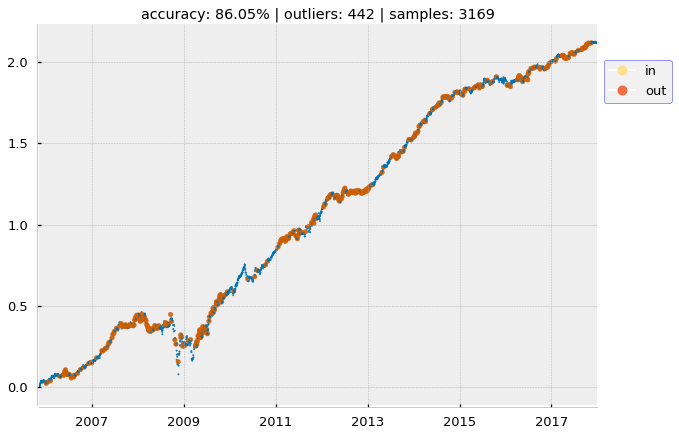

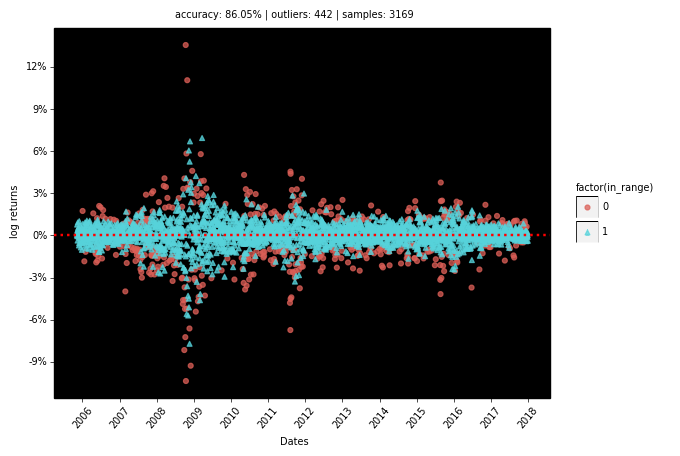

<ggplot: (-9223363275964358375)>


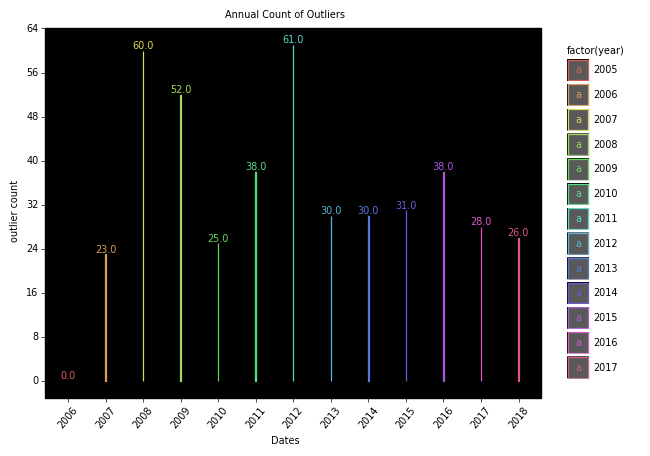

<ggplot: (-9223363275964809826)>


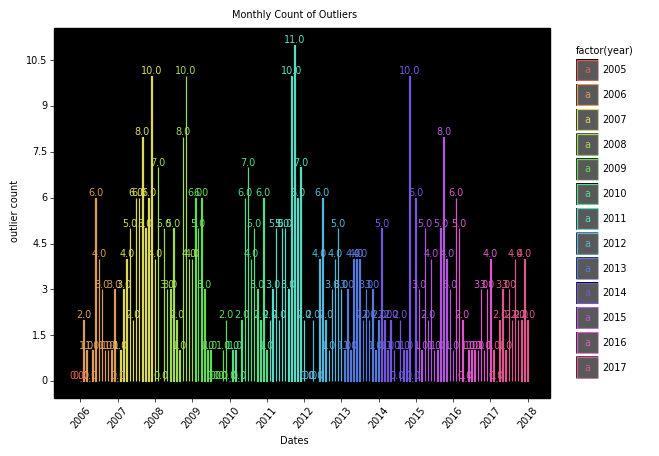

<ggplot: (-9223363275867543008)>
-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
            ith_state   ith_ret   ith_std    low_ci   high_ci  actual_return  \
2017-12-25        0.0  0.000338  0.002622 -0.004905  0.005553       0.000000   
2017-12-26        1.0  0.000349  0.002628 -0.004992  0.005462      -0.001197   
2017-12-27        1.0  0.000305  0.002595 -0.004732  0.005263       0.000486   
2017-12-28        0.0  0.000330  0.002589 -0.004840  0.005587       0.002055   
2017-12-29        0.0  0.000347  0.002593 -0.004841  0.005406      -0.003778   

            last_mean_class_0  last_mean_class_1  last_std_class_0  \
2017-12-25           0.000338           0.001194          0.002622   
2017-12-26           0.001191           0.000349          0.006172   
2017-12-27           0.001198           0.000305          0.006140   
2017-12-28           0.0

In [35]:
plot_all(pred_df.set_index('Dates'))
cprint(pred_df)

In [36]:
pred_df.describe().T

,count,mean,std,min,25%,50%,75%,max
ith_state,3169.0,0.484695,0.499845,0.000000e+00,0.000000,0.000000,1.000000,1.000000
ith_ret,3169.0,0.000450,0.001348,-7.347571e-03,-0.000027,0.000614,0.001405,0.002861
ith_std,3169.0,0.008301,0.006171,2.578401e-03,0.004546,0.006233,0.010359,0.043128
low_ci,3169.0,-0.015801,0.013099,-9.357919e-02,-0.019932,-0.011288,-0.007795,-0.004467
high_ci,3169.0,0.016707,0.011203,5.262918e-03,0.010239,0.013236,0.019906,0.079941
actual_return,3169.0,0.000246,0.011913,-1.036372e-01,-0.003682,0.000360,0.005110,0.135577
last_mean_class_0,3169.0,0.000105,0.001450,-7.347571e-03,-0.000698,0.000422,0.001061,0.002812
last_mean_class_1,3169.0,0.000081,0.001402,-6.654022e-03,-0.000695,0.000364,0.000980,0.002861
last_std_class_0,3169.0,0.010123,0.007631,2.578401e-03,0.005157,0.007930,0.012583,0.043128
last_std_class_1,3169.0,0.010339,0.007726,2.582502e-03,0.005442,0.008167,0.012921,0.042045


Very interesting that the accuracy of the return distribution prediction is better with less components. Although one could reason that with multiple distributions, when the incorrect component parameters are used to seed the distribution sampling that the errors/outliers can be compounded, but then what would be the purpose of using a "mixture" at all? Let's see if the event study can add clarity to this question.

## Design and implement an event study based on post outlier returns

In the next section we design an event study for the previously tagged `buys` from our prediction dataframe. Using code found [here, courtesy of Quantopian](https://www.quantopian.com/posts/research-looking-for-drift-an-event-study-with-share-buybacks-announcements), as template we can explore the possibility of a tradeable pattern.

The functions in the below cell all help to compute the return series beginning from $T_0-N$ days before the event at $T_0$ through $T_0 + N$ days after the event.

In [37]:
from datetime import timedelta

## below code is modified from the following link
##   https://www.quantopian.com/posts/research-looking-for-drift-an-event-study-with-share-buybacks-announcements

def get_close_price(data, current_date, day_number):
    #: If we're looking at day 0 just return the indexed date
    if day_number == 0:
        return data['close_price'].ix[current_date]
    #: Find the close price day_number away from the current_date
    else:
        #: If the close price is too far ahead, just get the last available
        total_date_index_length = len(data['close_price'].index)
        #: Find the closest date to the target date
        date_index = data['close_price'].index.searchsorted(current_date + timedelta(day_number))
        #: If the closest date is too far ahead, reset to the latest date possible
        date_index = total_date_index_length - 1 if date_index >= total_date_index_length else date_index
        #: Use the index to return a close price that matches
        return data['close_price'].iloc[date_index]
    
def get_first_price(data, starting_point, date):
    starting_day = date - timedelta(starting_point)
    date_index = data['close_price'].index.searchsorted(starting_day)
    return data['close_price'].iloc[date_index]

def remove_outliers(returns, num_std_devs):
    return returns[~((returns-returns.mean()).abs()>num_std_devs*returns.std())]

def get_returns(data, starting_point, date, day_num):
    #: Get stock prices
    first_price = get_first_price(data, starting_point, date)
    close_price = get_close_price(data, date, day_num)

    #: Calculate returns
    ret = (close_price - first_price)/(first_price + 0.0)
    return ret

The below code wraps the previous functions and computes the returns for all event paths. Note that in this example we will look at the returns `30 days` before and after the event. See the below code.

In [38]:
def run_event_study(pred_df, starting_point=30):
    """
    fn: wrapper for event study computations
    
    Params
    ------
        pred_df: pd.DataFrame with prediction data in it
        starting_point: int(), days to lookbackward and forward from event
    
    Returns
    -------
        all_returns: pd.Series
        all_std_devs: pd.Series
        N: int, number of samples
        all_returns_df: pd.DataFrame, all return series bundled
    """
    data = pred_df.query('buys==1').copy()
    #: Dictionaries that I'm going to be storing calculated data in 
    all_returns = {}
    all_std_devs = {}
    total_sample_size = {}

    #: Create our range of day_numbers that will be used to calculate returns
    #: Looking from -starting_point till +starting_point which creates our timeframe band
    day_numbers = [i for i in range(-starting_point, starting_point)]

    all_return_series = []

    for day_num in day_numbers:

        #: Reset our returns and sample size each iteration
        returns = []
        sample_size = 0

        #: Get the return compared to t=0 
        #for date, row in ev_data.iterrows():
        for row in data.itertuples():
            date = row.Index
            #sid = row.symbol

            #: Make sure that data exists for the dates
            #if date not in data['close_price'].index or sid not in data['close_price'].columns:
            #    continue

            returns.append(get_returns(data, starting_point, date, day_num))
            sample_size += 1

        #: Drop any Nans, remove outliers, find outliers and aggregate returns and std dev
        returns = pd.Series(returns).dropna()
        returns = remove_outliers(returns, 2)
        all_return_series.append(returns)
        all_returns[day_num] = np.average(returns)
        all_std_devs[day_num] = np.std(returns)
        total_sample_size[day_num] = sample_size

    #: Take all the returns, stds, and sample sizes that I got and put that into a Series
    all_returns = pd.Series(all_returns)
    all_std_devs = pd.Series(all_std_devs)
    N = np.average(pd.Series(total_sample_size))
    ## combine all return series into dataframe
    all_returns_df = pd.DataFrame(all_return_series, index=day_numbers)
    
    return all_returns, all_std_devs, N, all_returns_df

Below we output the results for evaluation.

In [39]:
all_returns, all_std_devs, N, all_returns_df = run_event_study(pred_df)

## Evaluate Event Study

Now that we have the results let's try to identify any tradeable patterns.

In this section we can organize the plots into functions for convenience when we want to evaluate different event study parameters.

In [44]:
def plot_mean_event_returns(all_returns, thres, starting_point=30):
    day_numbers = [i for i in range(-starting_point, starting_point)]
    xticks = [d for d in day_numbers if d%2 == 0]

    f, ax=plt.subplots(figsize=(12,7))
    (all_returns-all_returns.loc[0]).plot(xticks=xticks, ax=ax, 
                                          label=f"$N={N}$", legend=True)

    plt.axhline(0, ls='--', color=red)    
    plt.axvline(0, ls='--', color=red)
    plt.grid(b=None, which=u'major', axis=u'y')
    plt.title(f"Cumulative Return from buy signals given state prob. > ${thres}$")
    plt.xlabel("Window Length (t)")
    plt.legend()
    plt.ylabel("Cumulative Return ($r$)");
    
def plot_event_returns_all_paths(all_returns_df, thres, starting_point=30):
    day_numbers = [i for i in range(-starting_point, starting_point)]
    xticks = [d for d in day_numbers if d%2 == 0]

    f, ax = plt.subplots(figsize=(12,7))

    (all_returns_df-all_returns_df.mean(axis=1).loc[0]).plot(
        xticks=xticks, ax=ax, color='xkcd:light gray', legend=False, alpha=0.1)
    (all_returns_df.mean(axis=1)-all_returns_df.mean(axis=1).loc[0]).plot(
        xticks=xticks, ax=ax, color='xkcd:midnight blue', linewidth=3,
        label=f"$N={N}$", legend=True)
    ax.set_xlim(-starting_point, starting_point)
    ax.axhline(0, ls='--', color=red)
    ax.axvline(0, ls='--', color=red)
    plt.grid(b=None, which=u'major', axis=u'y')
    plt.title(f"Cumulative Return from buy signals given state prob. > ${thres}$ (all paths)")
    plt.xlabel("Window Length (t)")
    plt.ylabel("Cumulative Return (r)");
        

def plot_event_sharpe_estimate(all_returns,all_std_devs, thres, starting_point=30):
    day_numbers = [i for i in range(-starting_point, starting_point)]
    xticks = [d for d in day_numbers if d%2 == 0]

    f, ax=plt.subplots(figsize=(12,7))

    mod_sharpe = ((all_returns-all_returns.loc[0]) / all_std_devs)
    mod_sharpe.plot(xticks=xticks, ax=ax, label=f"$N={N}$", legend=True)

    #ax.axvline(mod_sharpe.idxmax(), ls='--', color=blue)    
    plt.axvline(0, ls='--', color=red)
    plt.axhline(0, ls='--', color=red)
    plt.grid(b=None, which=u'major', axis=u'y')
    plt.title(f"Sharpe estimate from buy signals with state prob. > ${thres}$")
    plt.xlabel("Window Length (t)")
    plt.legend()
    plt.ylabel("Sharpe Ratio ($\mu / \sigma$)");
    print(f'state prob. > ${thres}$ max sharpe ratio: {mod_sharpe.max():.3} at {mod_sharpe.idxmax()} days')
    
def plot_event_density(all_returns_df, thres):
    (pn.ggplot(pd.melt(all_returns_df).dropna(), pn.aes(x='value'))
     +pn.geom_density(pn.aes(y='..density..'))
     +pn.geom_histogram(pn.aes(y='..density..', bins=10), alpha=0.2)
     + pn.theme(axis_text_x=pn.element_text(rotation=50),
                text=pn.element_text(size=7), figure_size=(9,6))      
     + pn.ggtitle(f'Event study density with state prob. > ${thres}$')).draw();        

Example plots below.

state prob. > $0.5$ max sharpe ratio: 0.228 at 29 days


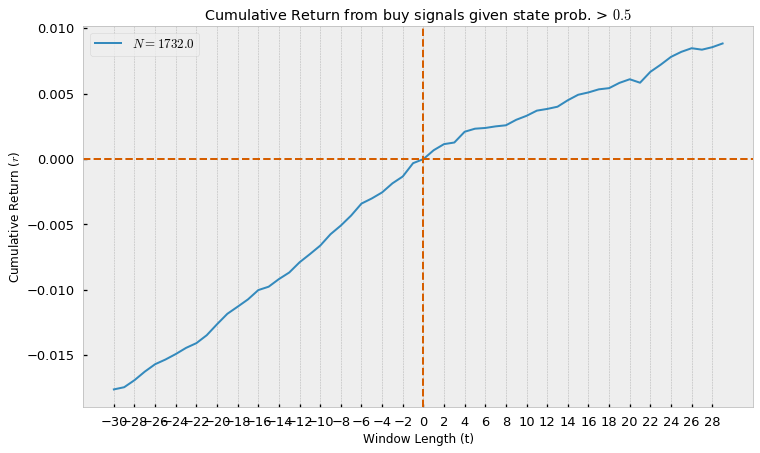

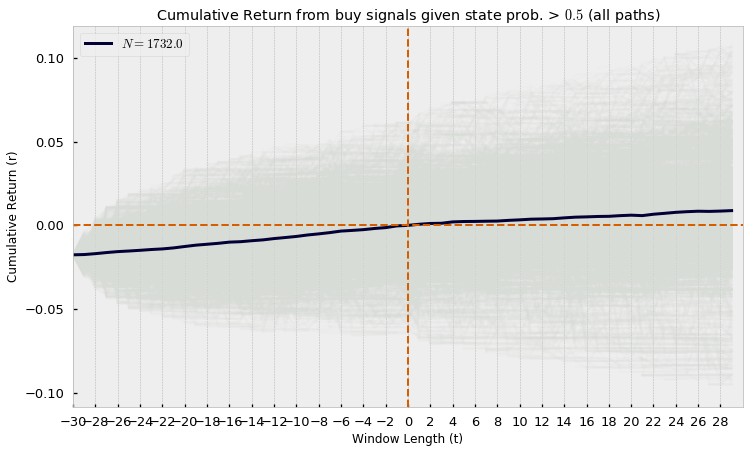

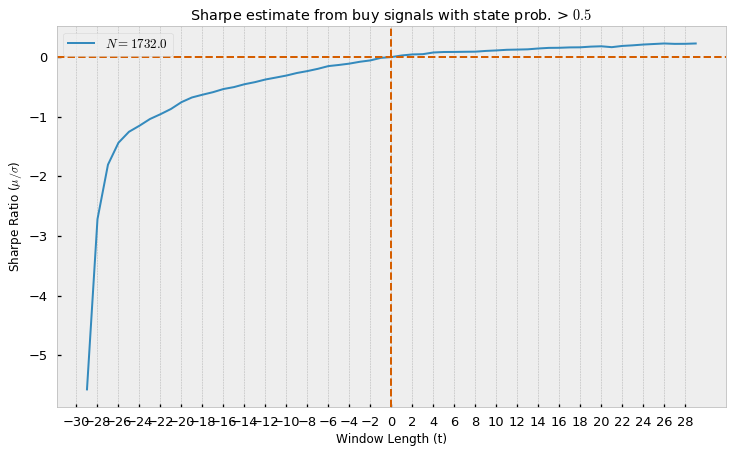

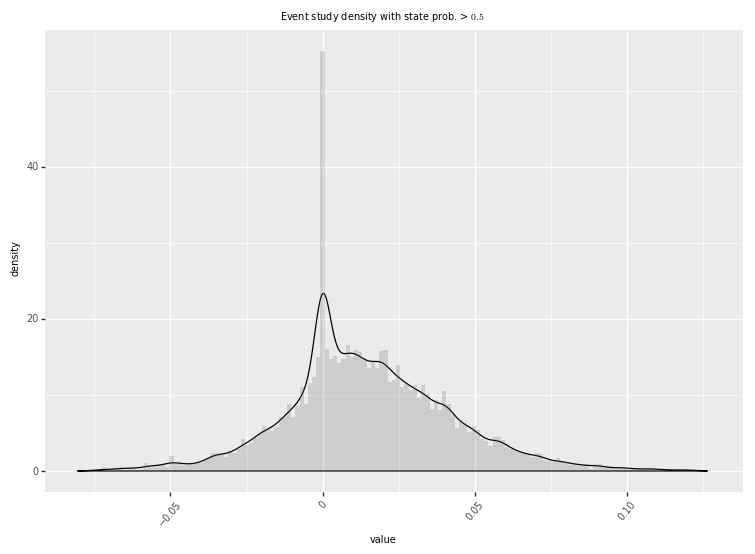

In [45]:
plot_mean_event_returns(all_returns, thres=THRES)
plot_event_returns_all_paths(all_returns_df, thres=THRES)    
plot_event_sharpe_estimate(all_returns, all_std_devs, thres=THRES)    
plot_event_density(all_returns_df, thres=THRES)    

## Run/Eval Event Study with Different Buy Thresholds

In this next section we will evaluate our event signal for different buy thresholds. Recall that in our final prediction dataframe we only indicate a potential buy if certain conditions are met. One of those conditions is our model's predicted probability of a particular regime. Below we will see if higher probability *(higher confidence)* equates to more profit potential.

state prob. > $0.5$ max sharpe ratio: 0.228 at 29 days
state prob. > $0.6$ max sharpe ratio: 0.287 at 29 days
state prob. > $0.7$ max sharpe ratio: 0.278 at 29 days
state prob. > $0.8$ max sharpe ratio: 0.379 at 29 days
state prob. > $0.9$ max sharpe ratio: inf at -30 days


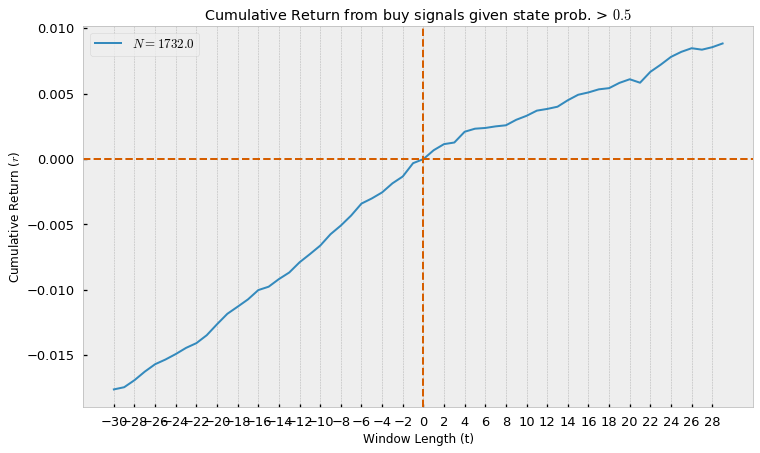

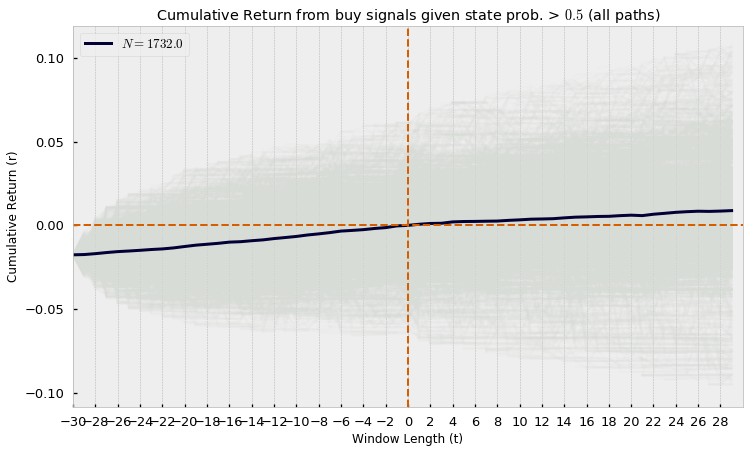

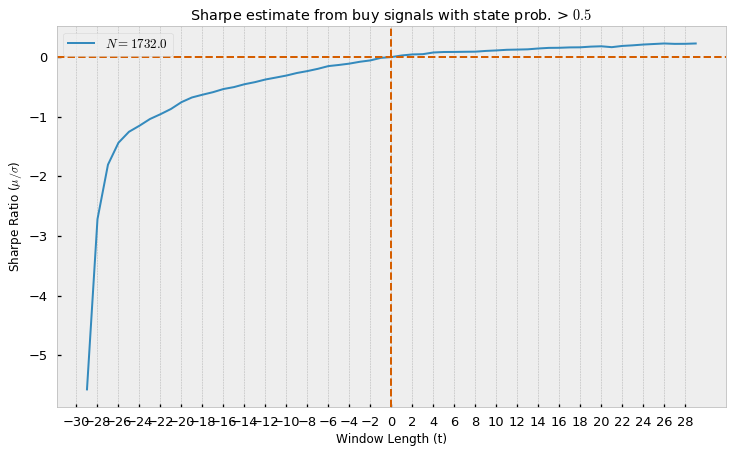

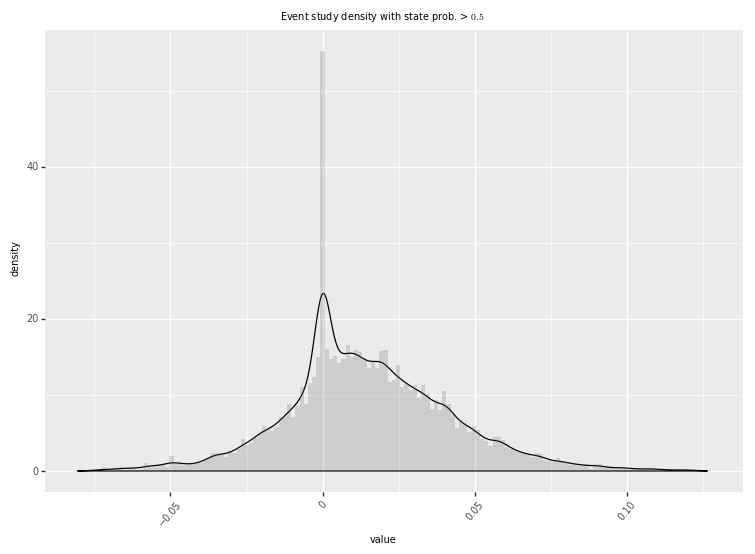

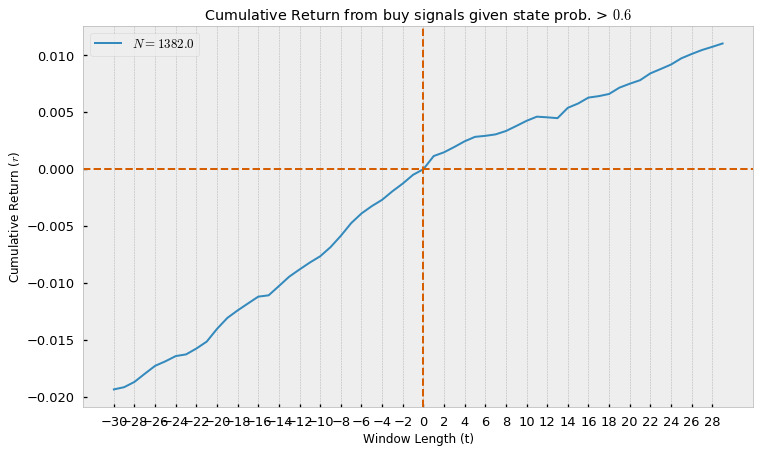

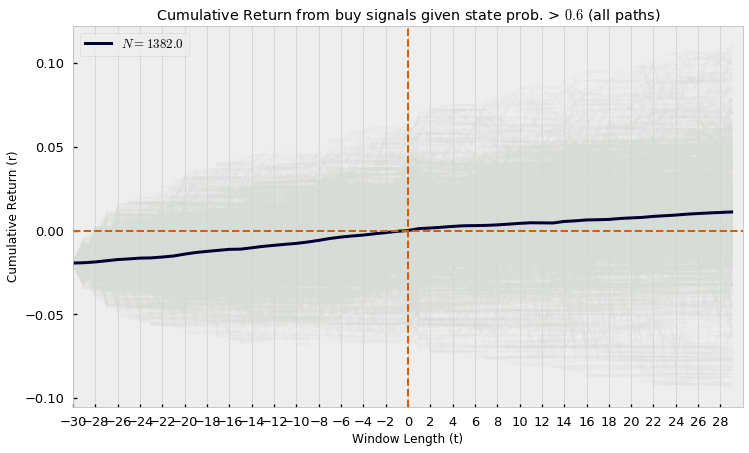

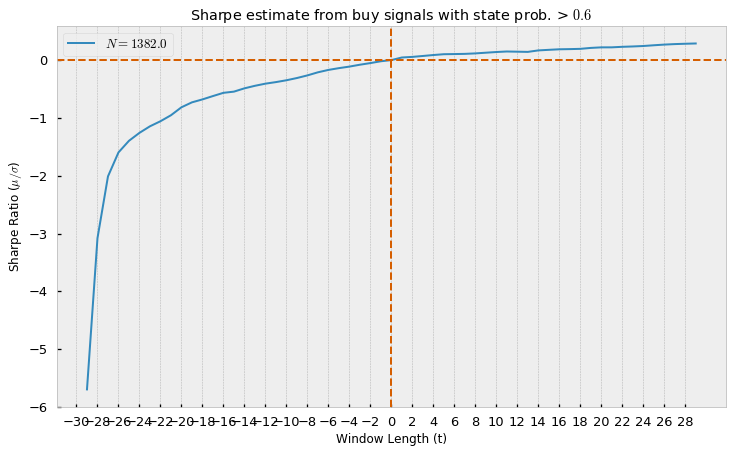

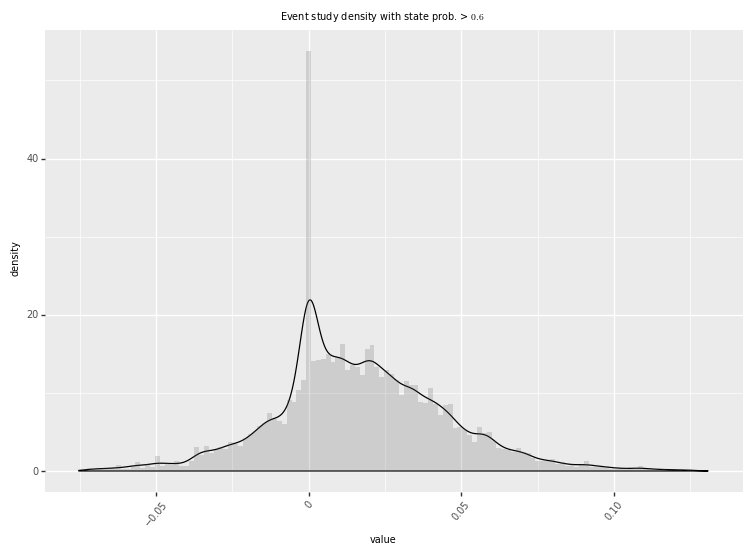

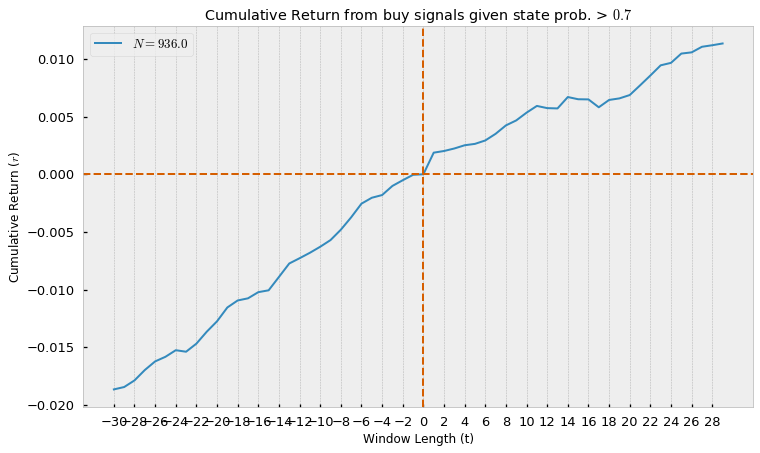

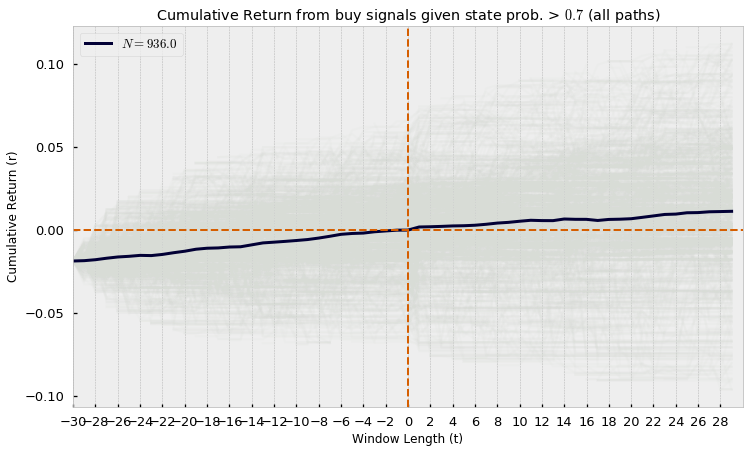

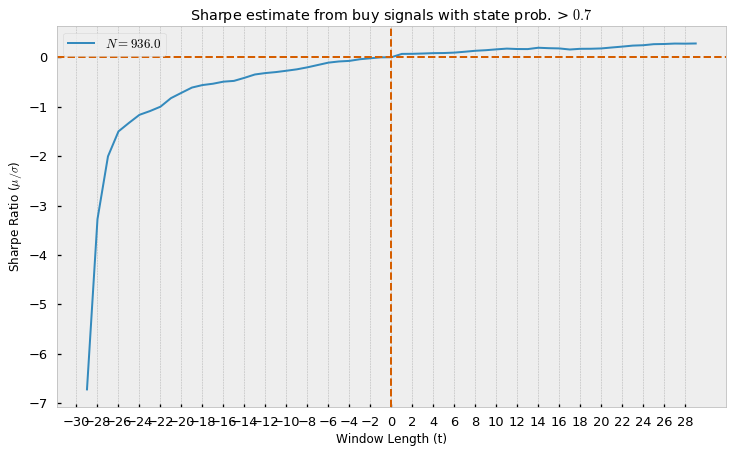

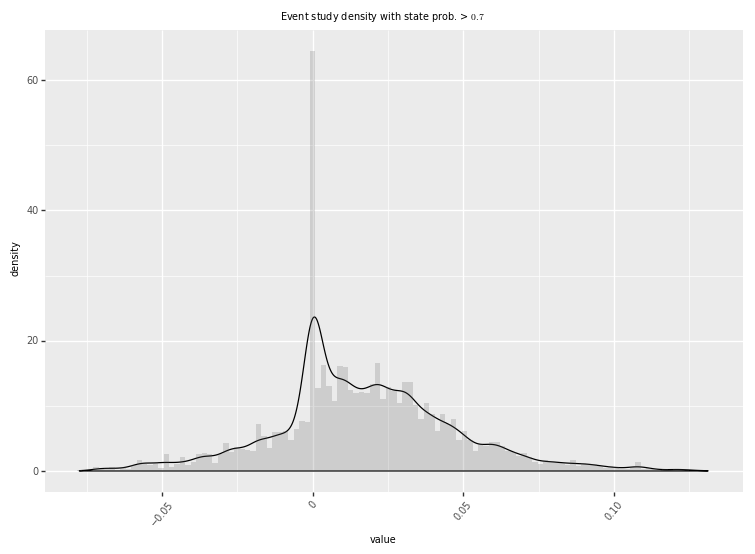

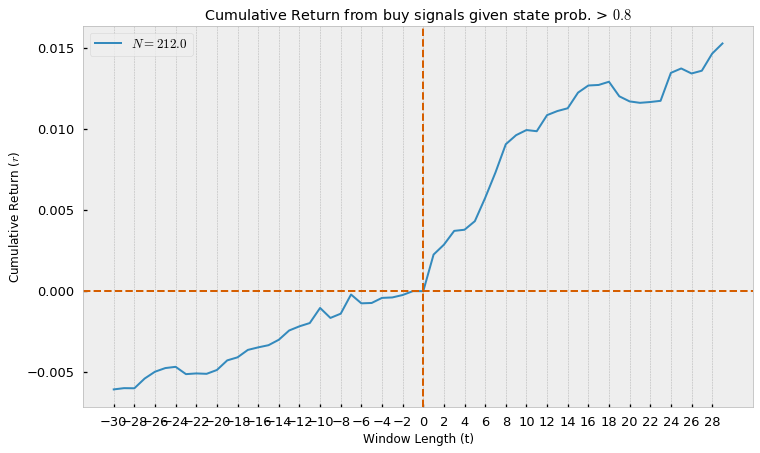

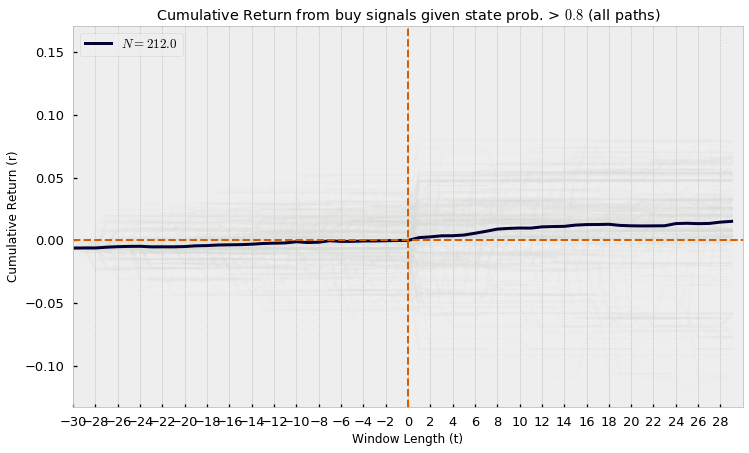

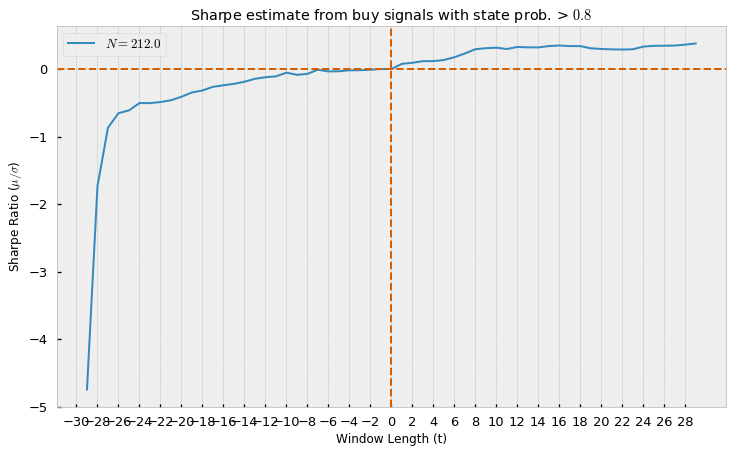

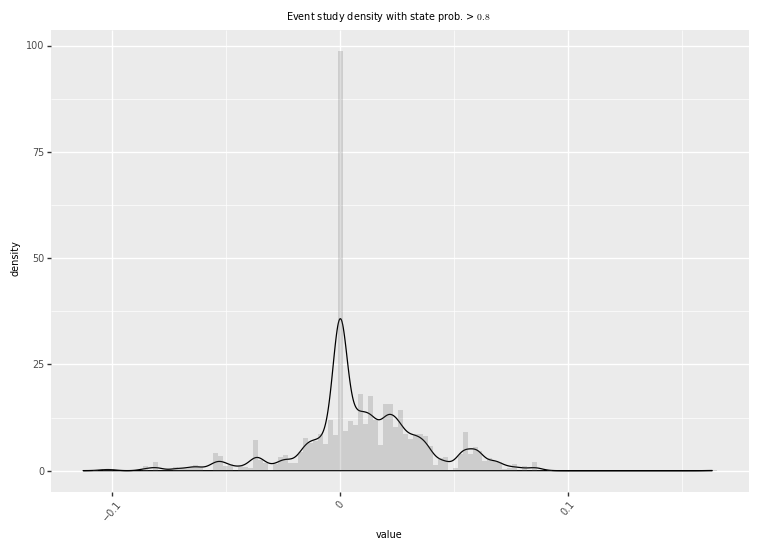

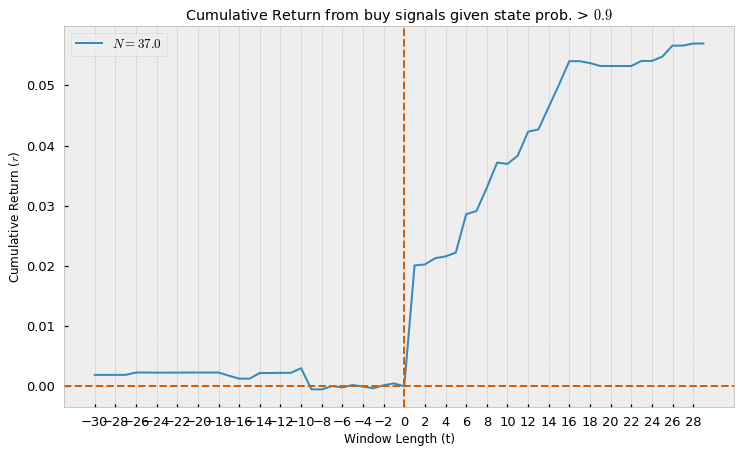

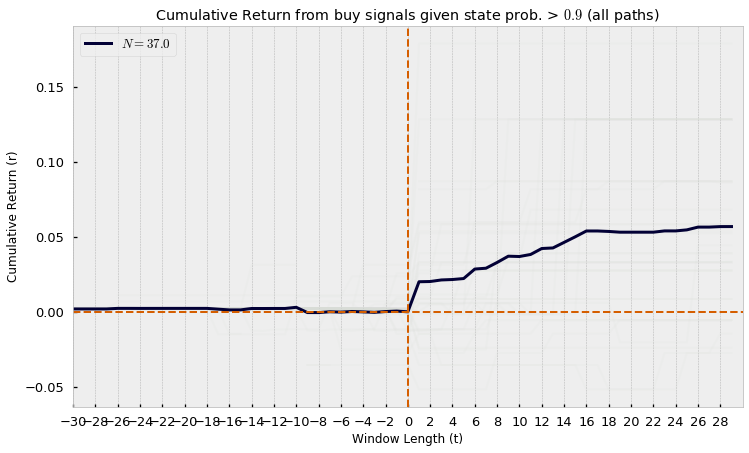

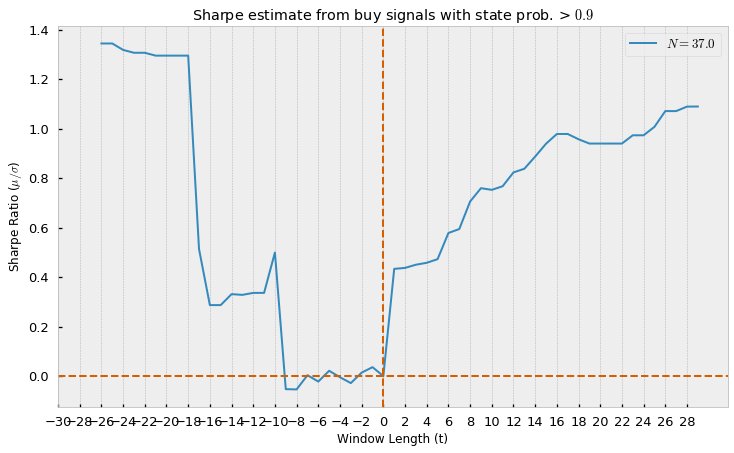

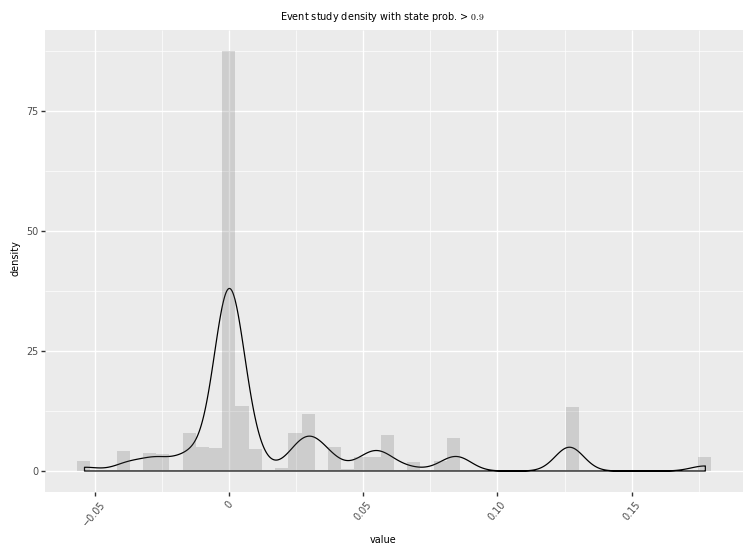

In [46]:
thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]    
for THRES in thresholds:
    pred_df = make_final_pred_df(pred_rows, cols, THRES, sym, prices)    
    # save pred_df for easy analysis
    outfp = PurePath(data_dir/f'two_state_daily_prediction_df_buy-thres_{THRES}.parq')
    pred_df.to_parquet(outfp)
    
    all_returns, all_std_devs, N, all_returns_df = run_event_study(pred_df)
    
    plot_mean_event_returns(all_returns, thres=THRES)
    plot_event_returns_all_paths(all_returns_df, thres=THRES)    
    plot_event_sharpe_estimate(all_returns, all_std_devs, thres=THRES)    
    plot_event_density(all_returns_df, thres=THRES)        

## Conclusions (Updated 2018-06-01)

In this notebook we examined one multi-layered approach to using Gaussian Mixture Models for trading applications. Based on the analysis we conducted it appears that there is potential tradeable pattern based on our filtering conditions. The most important condition being the model's confidence of the predicted regime. In the next section we will look at implementing a backtesting script to test this approach in a more realistic backtest.

* Note that at this point nothing can be said definitively because of the crude nature of the analysis. Backtesting performance will differ from our estimates for at least the following reasons:
    
    * Some theoretical trades overlap in time while a simple strategy will only take the first trade therefore some theoretical trades will be skipped/missed.
    * As mentioned above the sequence of trades can alter strategy returns up or down.
    * This study only looked at one asset thus the results may not generalize well.
    * Entry and exit criteria can alter returns dramatically especially when experimenting with different order types.
    * The probability distribution choice that we sample from will alter strategy returns dramatically. 
    * Trade costs, and slippage will lower theoretical returns.